<a href="https://colab.research.google.com/github/Nikhil5566/Machine-Learning/blob/main/Tensorflow_Deep_learning_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import collections

# Step 1: Load and Explore Dataset

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.K3WIYC_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.K3WIYC_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.K3WIYC_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
Training samples: 25000, Test samples: 25000


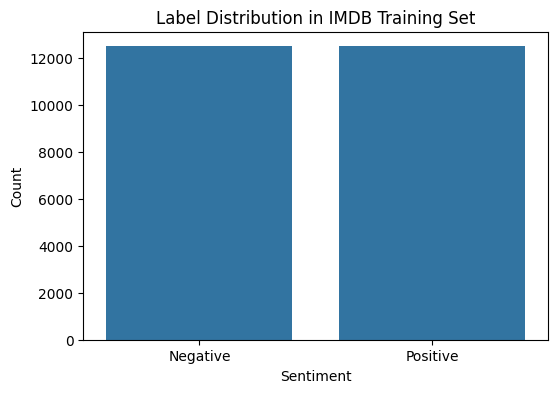

Average review length: 233.79 words
Max review length: 2470 words
Min review length: 10 words


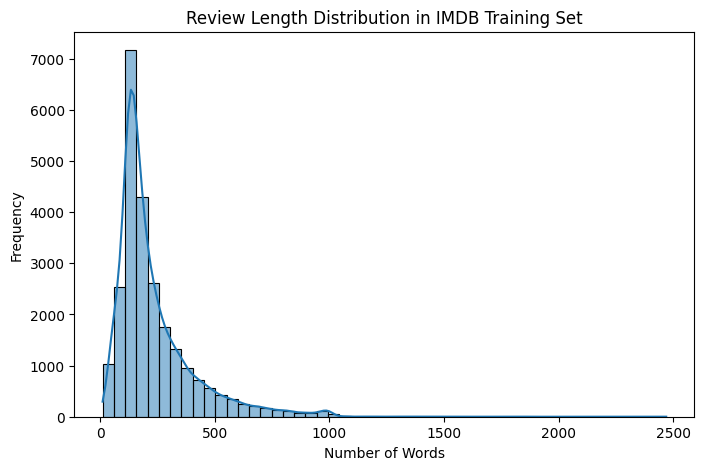


Top 10 most frequent words:
the: 322198
a: 159953
and: 158572
of: 144462
to: 133967
is: 104171
in: 90527
i: 70480
this: 69714
that: 66292


In [8]:
# Load IMDB dataset
(train_data, test_data), info = tfds.load('imdb_reviews', split=('train', 'test'), as_supervised=True, with_info=True)

# Convert to lists for exploration
train_data_list = [(text.numpy().decode('utf-8'), label.numpy()) for text, label in train_data]
test_data_list = [(text.numpy().decode('utf-8'), label.numpy()) for text, label in test_data]

# Basic statistics
print(f"Training samples: {len(train_data_list)}, Test samples: {len(test_data_list)}")

# Label distribution
labels = [label for _, label in train_data_list]
label_counts = collections.Counter(labels)
plt.figure(figsize=(6, 4))
sns.barplot(x=['Negative', 'Positive'], y=[label_counts[0], label_counts[1]])
plt.title("Label Distribution in IMDB Training Set")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.savefig("label_distribution.png")
plt.show()

# Review length distribution
review_lengths = [len(text.split()) for text, _ in train_data_list]
print(f"Average review length: {np.mean(review_lengths):.2f} words")
print(f"Max review length: {max(review_lengths)} words")
print(f"Min review length: {min(review_lengths)} words")
plt.figure(figsize=(8, 5))
sns.histplot(review_lengths, bins=50, kde=True)
plt.title("Review Length Distribution in IMDB Training Set")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.savefig("review_lengths.png")
plt.show()

# Top 10 most frequent words
word_freq = collections.Counter()
for text, _ in train_data_list:
    word_freq.update(text.lower().split())
print("\nTop 10 most frequent words:")
for word, freq in word_freq.most_common(10):
    print(f"{word}: {freq}")

# Step 2: Preprocess Data

In [9]:
# Text vectorization
max_tokens = 10000
max_len = 500  # Truncate/pad reviews to this length
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode='int',
    output_sequence_length=max_len
)

# Build vocabulary
train_texts = [text for text, _ in train_data_list]
vectorize_layer.adapt(train_texts)

# Prepare datasets
def prepare_data(text, label):
    text = vectorize_layer(text)
    return text, label

train_ds = train_data.map(prepare_data).batch(64).shuffle(1000).prefetch(tf.data.AUTOTUNE)
test_ds = test_data.map(prepare_data).batch(64).prefetch(tf.data.AUTOTUNE)

# Inspect a batch
for text_batch, label_batch in train_ds.take(1):
    print(f"Batch shape (text): {text_batch.shape}")  # [batch_size, max_len]
    print(f"Batch shape (labels): {label_batch.shape}")  # [batch_size]
    print(f"Sample batch indices (first review, first 10 tokens): {text_batch[0][:10]}")
    print(f"Sample batch labels (first 5): {label_batch[:5]}")

Batch shape (text): (64, 500)
Batch shape (labels): (64,)
Sample batch indices (first review, first 10 tokens): [   2  114   14   53 1603  255    2  315    5 1278]
Sample batch labels (first 5): [0 1 0 0 1]


# Step 3: Define Model

In [10]:
# Step 3: Define Model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_tokens, 100, mask_zero=True),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


# Step 4 Trian Model

Epoch 1/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 555s 1s/step - accuracy: 0.6250 - loss: 0.6215
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 539s 1s/step - accuracy: 0.8382 - loss: 0.3736
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 530s 1s/step - accuracy: 0.9040 - loss: 0.2503
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 540s 1s/step - accuracy: 0.9285 - loss: 0.1897
Epoch 5/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 526s 1s/step - accuracy: 0.9408 - loss: 0.1653


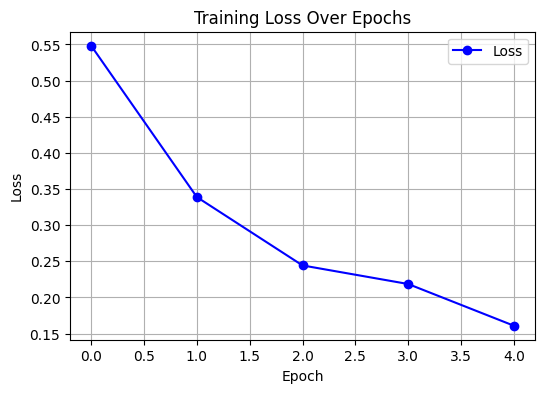

In [11]:
epochs = 5
history = model.fit(train_ds, epochs=epochs, verbose=1)

# Plot training loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], marker='o', color='b', label='Loss')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.savefig("training_loss.png")
plt.show()

# Step 5: Evaluate Model

In [12]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Save model
model.save("lstm_imdb_tf.h5")

391/391 ━━━━━━━━━━━━━━━━━━━━ 154s 393ms/step - accuracy: 0.8650 - loss: 0.3791


Test Accuracy: 86.43%


In [14]:
# Display test accuracy
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Display sample predictions (using TensorFlow approach since test_ds is available)
print("\nSample Predictions:")
for text_batch, label_batch in test_ds.take(1):
    predictions = model.predict(text_batch)
    for i in range(min(5, text_batch.shape[0])): # Display up to 5 samples
        sentiment = "Positive" if predictions[i][0] > 0.5 else "Negative"
        actual_label = "Positive" if label_batch[i].numpy() == 1 else "Negative"
        print(f"  Prediction: {sentiment}, Actual: {actual_label}")

Test Accuracy: 86.43%

Sample Predictions:
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 250ms/step
  Prediction: Positive, Actual: Positive
  Prediction: Positive, Actual: Positive
  Prediction: Negative, Actual: Negative
  Prediction: Negative, Actual: Negative
  Prediction: Positive, Actual: Positive
